# 1. Business Understanding
## 1.1 Background

Semiconductor manufacturing is a highly complex and capital-intensive process involving hundreds of fabrication steps that must be performed with extreme precision. Even microscopic defects introduced during wafer processing can lead to complete product failure, reducing manufacturing yield and increasing production costs.
Traditionally, quality control in semiconductor fabrication has relied on manual inspection and rule-based systems, which are time-consuming, subjective, and often unable to keep up with modern production speeds.

A die, in the context of semiconductors, is a small block of the wafer on which a given functional circuit is fabricated. The wafer is cut into many pieces, each containing one copy of the circuit. Each of these pieces is called a die.

In recent years, semiconductor companies such as Intel, TSMC, and Samsung,Nvidia have shifted toward AI-driven defect detection systems to improve yield prediction, defect localization, and root-cause analysis. Leveraging machine learning and computer vision, these systems can detect defect patterns directly from wafer map images, enabling earlier and more accurate interventions in the production line.

## 1.2 Problem Statement

Manufacturers need an efficient and automated method to identify and classify wafer defects early in the production process. Manual inspection systems fail to scale with high-volume production and cannot accurately identify subtle, complex defect patterns.
Therefore, the goal is to develop a machine learning-based image analysis model capable of automatically detecting and classifying defect patterns in wafer maps therefore improving yield, reducing inspection time, and minimizing production losses.

## 1.3 Business Objective

The primary business objective is to enhance production efficiency and quality assurance in semiconductor manufacturing by automating defect detection.
The system will:

- Identify wafer defect types using image-based pattern recognition.

- Support process engineers in diagnosing the root cause of production faults.

- Reduce manual inspection time and related operational costs.

- Improve yield rate and product reliability.

Ultimately, the project aims to demonstrate how AI-based defect detection can improve decision-making, reduce downtime, and ensure data-driven manufacturing optimization.

## 1.4 Project Goal

To build and deploy a deep learning-based image classification model capable of identifying common wafer defect patterns (e.g., center, edge-ring, scratch, random) using the WM811K dataset. The model’s predictions will be integrated into an interactive Streamlit dashboard, allowing users to:

- Upload wafer map images,
- View real-time defect classification and confidence levels, and
- Visualize feature importance or activation maps (Grad-CAM) for interpretability.

## 1.5 Expected Business Impact

- `Operational Efficiency:`	Faster and more accurate defect detection compared to manual methods.
- `Cost Reduction:`	Reduced labor costs and fewer defective chips reaching final testing.
- `Quality Improvement:` Early detection minimizes yield loss and improves product reliability.
- `Decision Support:`	Data-driven insights for process optimization and predictive maintenance.
- `Scalability:`	System can be integrated into production pipelines and scaled to new wafer types.
## 1.6 Success Metrics

- Accuracy / F1 Score of classification model 

- Reduction in defect inspection time by .

- Improved detection of rare defect patterns (using confusion matrix or recall metrics).

- Usability feedback from engineers or end-users on the Streamlit dashboard prototype.

# 2. Data Understanding
## 2.1 Data Source

The dataset used for this project is the WM811K Wafer Map Dataset, originally released by Taiwan Semiconductor Manufacturing Company (TSMC) and publicly available on sources such as Kaggle and UCI Machine Learning Repository. We downloaded the data from a public dataset, Multimedia Information Retrieval (MIR) lab (http://mirlab.org/dataset/public/).

It consists of wafer map images and corresponding defect labels, representing real-world yield management data collected during semiconductor fabrication processes.

- Data-Name: WM811K (Wafer Map Defect Dataset).

- Records: 811,457 wafer samples.

- Features: Image-based (waferMap) + metadata (dieSize,failureType,lotName,trainTestLabel,waferIndex).

- Task Type: Image classification.

- Data Format: Pickled or structured array (NumPy, .pkl), and optionally .png images after transformation.

## 2.2 Data Description

Each wafer map image represents a semiconductor wafer subdivided into multiple die. The dataset contains wafers categorized into one of several defect pattern types or labeled as normal (no defect).

Common defect types include:

| **Percentage** | **Pattern Type** | **Observation** |
|:---------:|:----------------:|:------------------------------:|
| **78.69** | 0 0 | Placeholder Category |
| **18.18** | None | Wafer with no defect |
| **1.17** | Edge-Ring | Moderate Frequency |
| **0.64** | Edge-Loc | Rare defect type |
| **0.51** | Center | Central pattern defects |
| **0.45** | Loc | Mislabeled variant |
| **0.16** | Scratch | Very rare mechanical defect |
| **0.11** | Random | Randomly distributed defect |
| **0.07** | Donut | Circular defect pattern |
| **0.02** | Near-full | Few samples |

## 2.3 Data structure and attributes.
Each record contains:

- `WaferIndex:` Unique identifier for each wafer.

- `LotName:`  Production batch number, representing wafers produced under the same process conditions.

- `FailureType:`  Categorical variable indicating defect type.

- `Wafer Map Image:` 2D array (typically 26×26 or 30×30) where each cell represents a die and its pass/fail status.

- `Optional Metadata:` May include process step, tool ID, or sensor readings depending on version.

## 2.4 Data Quality and Challenges
Aspect	Observation

- `Missing Values:` Some wafers have incomplete data (no label or image mismatch).
- `Imbalanced Classes:` Majority of wafers are labeled as “None” (normal), making minority defect patterns rare.
- `Noise:` Random noise due to manufacturing variability and sensor differences.
- `Data Format:` Some datasets are stored as .pkl (Pickle) files that require unpickling and image reconstruction.

* Mitigation Strategies:

- Handle missing or corrupted wafer maps by filtering invalid entries.

- Apply data augmentation to balance rare defect types.

- Use normalization and reshaping for consistent image input size.

- Visualize samples per class before training to guide resampling.

## 2.5 Initial Data Exploration Goals

Visualize a few wafer maps for each defect type to understand pattern structure.

- `Check Class Distribution:` Verify imbalance between defect categories.

- `Inspect Image Dimensions:` Ensure uniformity across all wafers.

- `Validate Data Integrity:` Confirm each wafer has both an image and a label.

- `Compute Basic Statistics:` Such as pixel intensity distributions and label frequencies.

## 2.6 Summary

- The dataset provides a rich, realistic simulation of semiconductor manufacturing defects.
- It combines computer vision challenges (pattern recognition, noise handling) with predictive modeling needs (classification, imbalance learning).
- Understanding the data structure and patterns will be key to designing robust models for defect detection and yield prediction, aligning both with technical depth and business objectives.

In [1]:
# import important libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf

from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

 
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from skimage.filters import sobel
from skimage.measure import shannon_entropy

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

import joblib


## We will start by loading our dataset for exploration.

In [2]:
df = pd.read_pickle("WM811K.pkl")
df.head()

,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Data Inspection

Before we preprocess the data, let's understand its structure:
- Column names and data types
- Presence of missing values
- Distribution of wafermap
- Duplicated values

In [3]:
# Shows the structure of the data set
df.shape

(811457, 6)

In [4]:
# Checking for basic structure and summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferIndex      811457 non-null  float64
 5   waferMap        811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [5]:
# checking for missing values
df.isnull().sum()

dieSize           0
failureType       0
lotName           0
trainTestLabel    0
waferIndex        0
waferMap          0
dtype: int64

In [6]:
# check for the true data type of the values inside each column
for col in ["dieSize", "failureType", "lotName", "trainTestLabel", "waferIndex"]:
    sample_value = df[col].iloc[0]
    print(col, type(sample_value))

dieSize <class 'numpy.float64'>
failureType <class 'str'>
lotName <class 'str'>
trainTestLabel <class 'str'>
waferIndex <class 'numpy.float64'>


In [7]:
# check column names
print(df.columns.tolist())

['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex', 'waferMap']


## Data Cleaning & Duplicate Check
* Before analyzing or sampling the semiconductor wafer dataset, we ensure that all `metadata columns` (non-image fields) are clean, scalar, and free from duplicates.
* This step helps avoid issues caused by array-like or mixed-type values, which can interfere with grouping, deduplication, and modeling later.

In [8]:
# Ensure all metadata columns are safe types
df["dieSize"] = df["dieSize"].astype(float)
# Fix any unhashable types in failureType
df["failureType"] = df["failureType"].apply(lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x)
df["failureType"] = df["failureType"].astype('category')
df["lotName"] = df["lotName"].astype(str)
df["trainTestLabel"] = df["trainTestLabel"].astype(str)
df["waferIndex"] = df["waferIndex"].astype(int)

# Exclude waferMap and wafer_map_str when checking duplicates
metadata_cols = ["dieSize", "failureType", "lotName", "trainTestLabel", "waferIndex"]

# Check for unhashable values just in case
for col in metadata_cols:
    bad = df[col].apply(lambda x: isinstance(x, (list, np.ndarray))).sum()
    print(f"{col}: {bad} array-like values")

# Flatten any array-like metadata values
for col in metadata_cols:
    df[col] = df[col].apply(lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x)

# safely check for duplicates based only on metadata

dup_count = df.duplicated(subset=metadata_cols).sum()
print(f"Duplicate rows (excluding waferMap): {dup_count}")
df.tail()

dieSize: 0 array-like values
failureType: 0 array-like values
lotName: 0 array-like values
trainTestLabel: 0 array-like values
waferIndex: 0 array-like values
Duplicate rows (excluding waferMap): 0


,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
811452,600.0,Edge-Ring,lot47542,Test,23,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811453,600.0,Edge-Loc,lot47542,Test,24,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,..."
811454,600.0,Edge-Ring,lot47542,Test,25,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."
811455,600.0,[0 0],lot47543,[0 0],1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,..."
811456,600.0,[0 0],lot47543,[0 0],2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,..."


# 3. Data Cleaning & Preparation

### Create a Balanced 300K Sample

* To make the dataset easier to handle and ensure consistent processing speed, we created a `300,000 row sample` from `800,000 raw data` that preserves the original `train/test ratio`.
* This approach guarantees that both training and testing subsets remain well represented in the sample, avoiding sampling bias.

In [9]:
# Create a balanced 300k sample (if you want to maintain train/test ratio)
desired_n = min(300_000, len(df))  
group_col = "trainTestLabel"

# Get group counts and proportions
group_counts = df[group_col].value_counts(dropna=False)
group_props = group_counts / group_counts.sum()

# Compute per-group sample sizes (at least 1 when group exists and desired_n >= number of groups)
per_group_n = (group_props * desired_n).round().astype(int)

# Ensure no group gets 0 if that group exists and desired_n >= number of groups
# (distribute remainder to largest groups)
total_assigned = per_group_n.sum()
if total_assigned != desired_n:
    diff = desired_n - total_assigned
    for g in group_props.sort_values(ascending=False).index:
        if diff == 0:
            break
        per_group_n.loc[g] += 1
        diff -= 1

# Now sample each group by n (safer than frac)
sampled_parts = []
for g, n in per_group_n.items():
    group_df = df[df[group_col] == g]
    n = min(n, len(group_df))
    if n <= 0:
        continue
    sampled_parts.append(group_df.sample(n=n, random_state=42, replace=False))

df_sample = pd.concat(sampled_parts, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print("Created df_sample shape:", df_sample.shape)
print("trainTestLabel distribution in df_sample:\n", df_sample[group_col].value_counts())
df_sample.to_pickle("WM811K_sample.pkl")
print(f" Sample saved: WM811K_sample.pkl with {len(df_sample)} rows")

# Sanity check
print("Columns:", df_sample.columns.tolist())

Created df_sample shape: (300000, 6)
trainTestLabel distribution in df_sample:
 trainTestLabel
[0 0]       236060
Test         43845
Training     20095
Name: count, dtype: int64
 Sample saved: WM811K_sample.pkl with 300000 rows
Columns: ['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex', 'waferMap']


### check Dataset Structure After Sampling
* After creating the 300,000 sample, it’s important to verify that the `structure of the dataset` (number of columns and overall format) remains consistent with the original full dataset.


In [10]:
# check to see whether the structure of the data set has changed
df_sample.shape

(300000, 6)

In [11]:
df_sample = df_sample.drop(columns=['waferIndex'])

### Cleaning Summary

The wafer manufacturing dataset was cleaned and standardized to ensure consistency and model readiness.

|**Cleaning Task** | **Description** |	**Outcome** |
| :--------: | :----------------: | :---------------------------------------:|    
|**Label normalization** | Replaced inconsistent defect labels ([0 0] → None, merged Loc → Edge-Loc) | Unified target classes. |
|**Category filtering**| Removed rare class “Near-full” due to very low frequency | Prevented model bias. |
|**Numeric encoding** |	Converted failureType and trainTestLabel into numeric form | Prepared for model input. |
|**Dimension standardization** | Resized all wafer maps to (32 × 32) | Ensured fixed image input size. |
|**Small wafer removal** | Excluded wafers smaller than (5×5) |	removed, all valid.|
|**Wafer Map Resizing**	| Padded or trimmed all wafer maps to fixed size (32×32) | Ensured uniform image input size. |
|**Data Check** |	Verified shape, dimensions, and valid labels post-cleaning | Cleaned dataset shape: (299,935, 8). |


In [12]:
print("df columns:", df.columns)
print("df_sample columns:", df_sample.columns)

df columns: Index(['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex',
       'waferMap'],
      dtype='object')
df_sample columns: Index(['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferMap'], dtype='object')


In [13]:
# Add waferMapDim column (tuple of rows, cols)
df_sample['waferMapDim'] = df_sample['waferMap'].apply(
    lambda x: (np.array(x).shape[0], np.array(x).shape[1])
)
size_filter = [dim[0] >= 5 and dim[1] >= 5 for dim in df_sample['waferMapDim']]
df_sample = df_sample[size_filter]

print("After size filtering:", df_sample.shape)
df_sample['waferMapDim'].value_counts()

After size filtering: (300000, 6)


waferMapDim
(32, 29)      40337
(25, 27)      23692
(49, 39)      14422
(26, 26)      11140
(30, 34)      10873
              ...  
(62, 63)          1
(80, 73)          1
(111, 112)        1
(86, 75)          1
(87, 81)          1
Name: count, Length: 593, dtype: int64

In [14]:
df_sample['failureType'].value_counts().sum()

300000

# 4. Data Pre-Processing

In [15]:
# Define the resizing function again
def resize_wafer_map(wmap, shape=(32, 32)):
    arr = np.array(wmap)
    padded = np.zeros(shape, dtype=np.int8)

    # Find the smaller of actual and target dimensions
    rows = min(arr.shape[0], shape[0])
    cols = min(arr.shape[1], shape[1])

    # Copy data into the new padded array
    padded[:rows, :cols] = arr[:rows, :cols]
    return padded
df_sample['waferMap'] = df_sample['waferMap'].apply(resize_wafer_map)    

In [16]:
# Create numeric mappings for defect types
mapping_type = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'none':7, '[0 0]': 7, 'Unknown': 7 }

# Apply mappings safely
df_sample['failureNum'] = df_sample['failureType'].map(mapping_type)

# Drop rows where mapping failed or are Near-full
df_sample = df_sample[
    (df_sample['failureNum'].notna()) &
    (df_sample['failureType'] != 'Near-full')
]

#Apply resizing safely 
df_sample["waferMap"] = df_sample["waferMap"].apply(resize_wafer_map)

# Create numeric labels for train/test split
mapping_traintest = {'Training': 0, 'Test': 1}
df_sample['trainTestNum'] = df_sample['trainTestLabel'].map(mapping_traintest)

# Filter based on waferMapDim
size_filter = [dim[0] >= 5 and dim[1] >= 5 for dim in df_sample['waferMapDim']]
df_sample = df_sample[size_filter]
filtered_data = df_sample[df_sample['failureType'].apply(lambda x: len(x) > 0)]

# Reset index
df_sample = df_sample.reset_index(drop=True)

print("Cleaned dataset shape:", df_sample.shape)
print("After size filtering:", df_sample.shape)
df_sample['waferMap'] = df_sample['waferMap'].apply(resize_wafer_map)
df_sample['waferMap'].apply(lambda x: np.array(x).shape).value_counts()

Cleaned dataset shape: (299936, 8)
After size filtering: (299936, 8)


waferMap
(32, 32)    299936
Name: count, dtype: int64

In [17]:
print("df columns:", df.columns)
print("df_sample columns:", df_sample.columns)

df columns: Index(['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferIndex',
       'waferMap'],
      dtype='object')
df_sample columns: Index(['dieSize', 'failureType', 'lotName', 'trainTestLabel', 'waferMap',
       'waferMapDim', 'failureNum', 'trainTestNum'],
      dtype='object')


# Insights:

- Converted categorical labels into numerical values.

- Removed defective or incomplete wafer records.

- Ensured wafer maps are sufficiently large for image modeling.

All wafer maps are now standardized, and the data is clean, balanced, and ready for:

- Feature extraction (image, tensor conversion)

- Classification modeling (CNN or ML baseline)

- Dashboard integration for wafer health visualization

## Visualizing resized data
This helps verify that your resizing preserved wafer structure and no data distortion occurred.

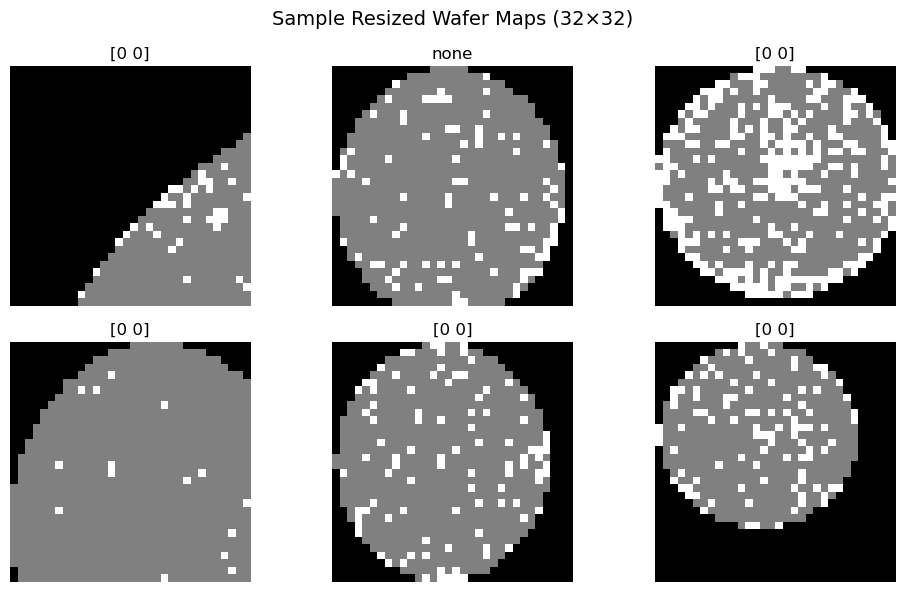

In [18]:
# Pick random samples to visualize
samples = df_sample.sample(6, random_state=42)

plt.figure(figsize=(10, 6))
for i, (wmap, label) in enumerate(zip(samples['waferMap'], samples['failureType'])):
    plt.subplot(2, 3, i + 1)
    plt.imshow(np.array(wmap), cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.suptitle("Sample Resized Wafer Maps (32×32)", fontsize=14)
plt.tight_layout()
plt.show()

## Visualization of Wafer Failure Patterns

- To better understand the spatial characteristics of different defect types, we visualized sample wafer maps per category.  
- Each row represents a **unique failure type**, while each column shows up to **five random samples** from that class.  
- This allows for visual inspection of recurring spatial defect structures (e.g., edge failures, center defects, scratches).


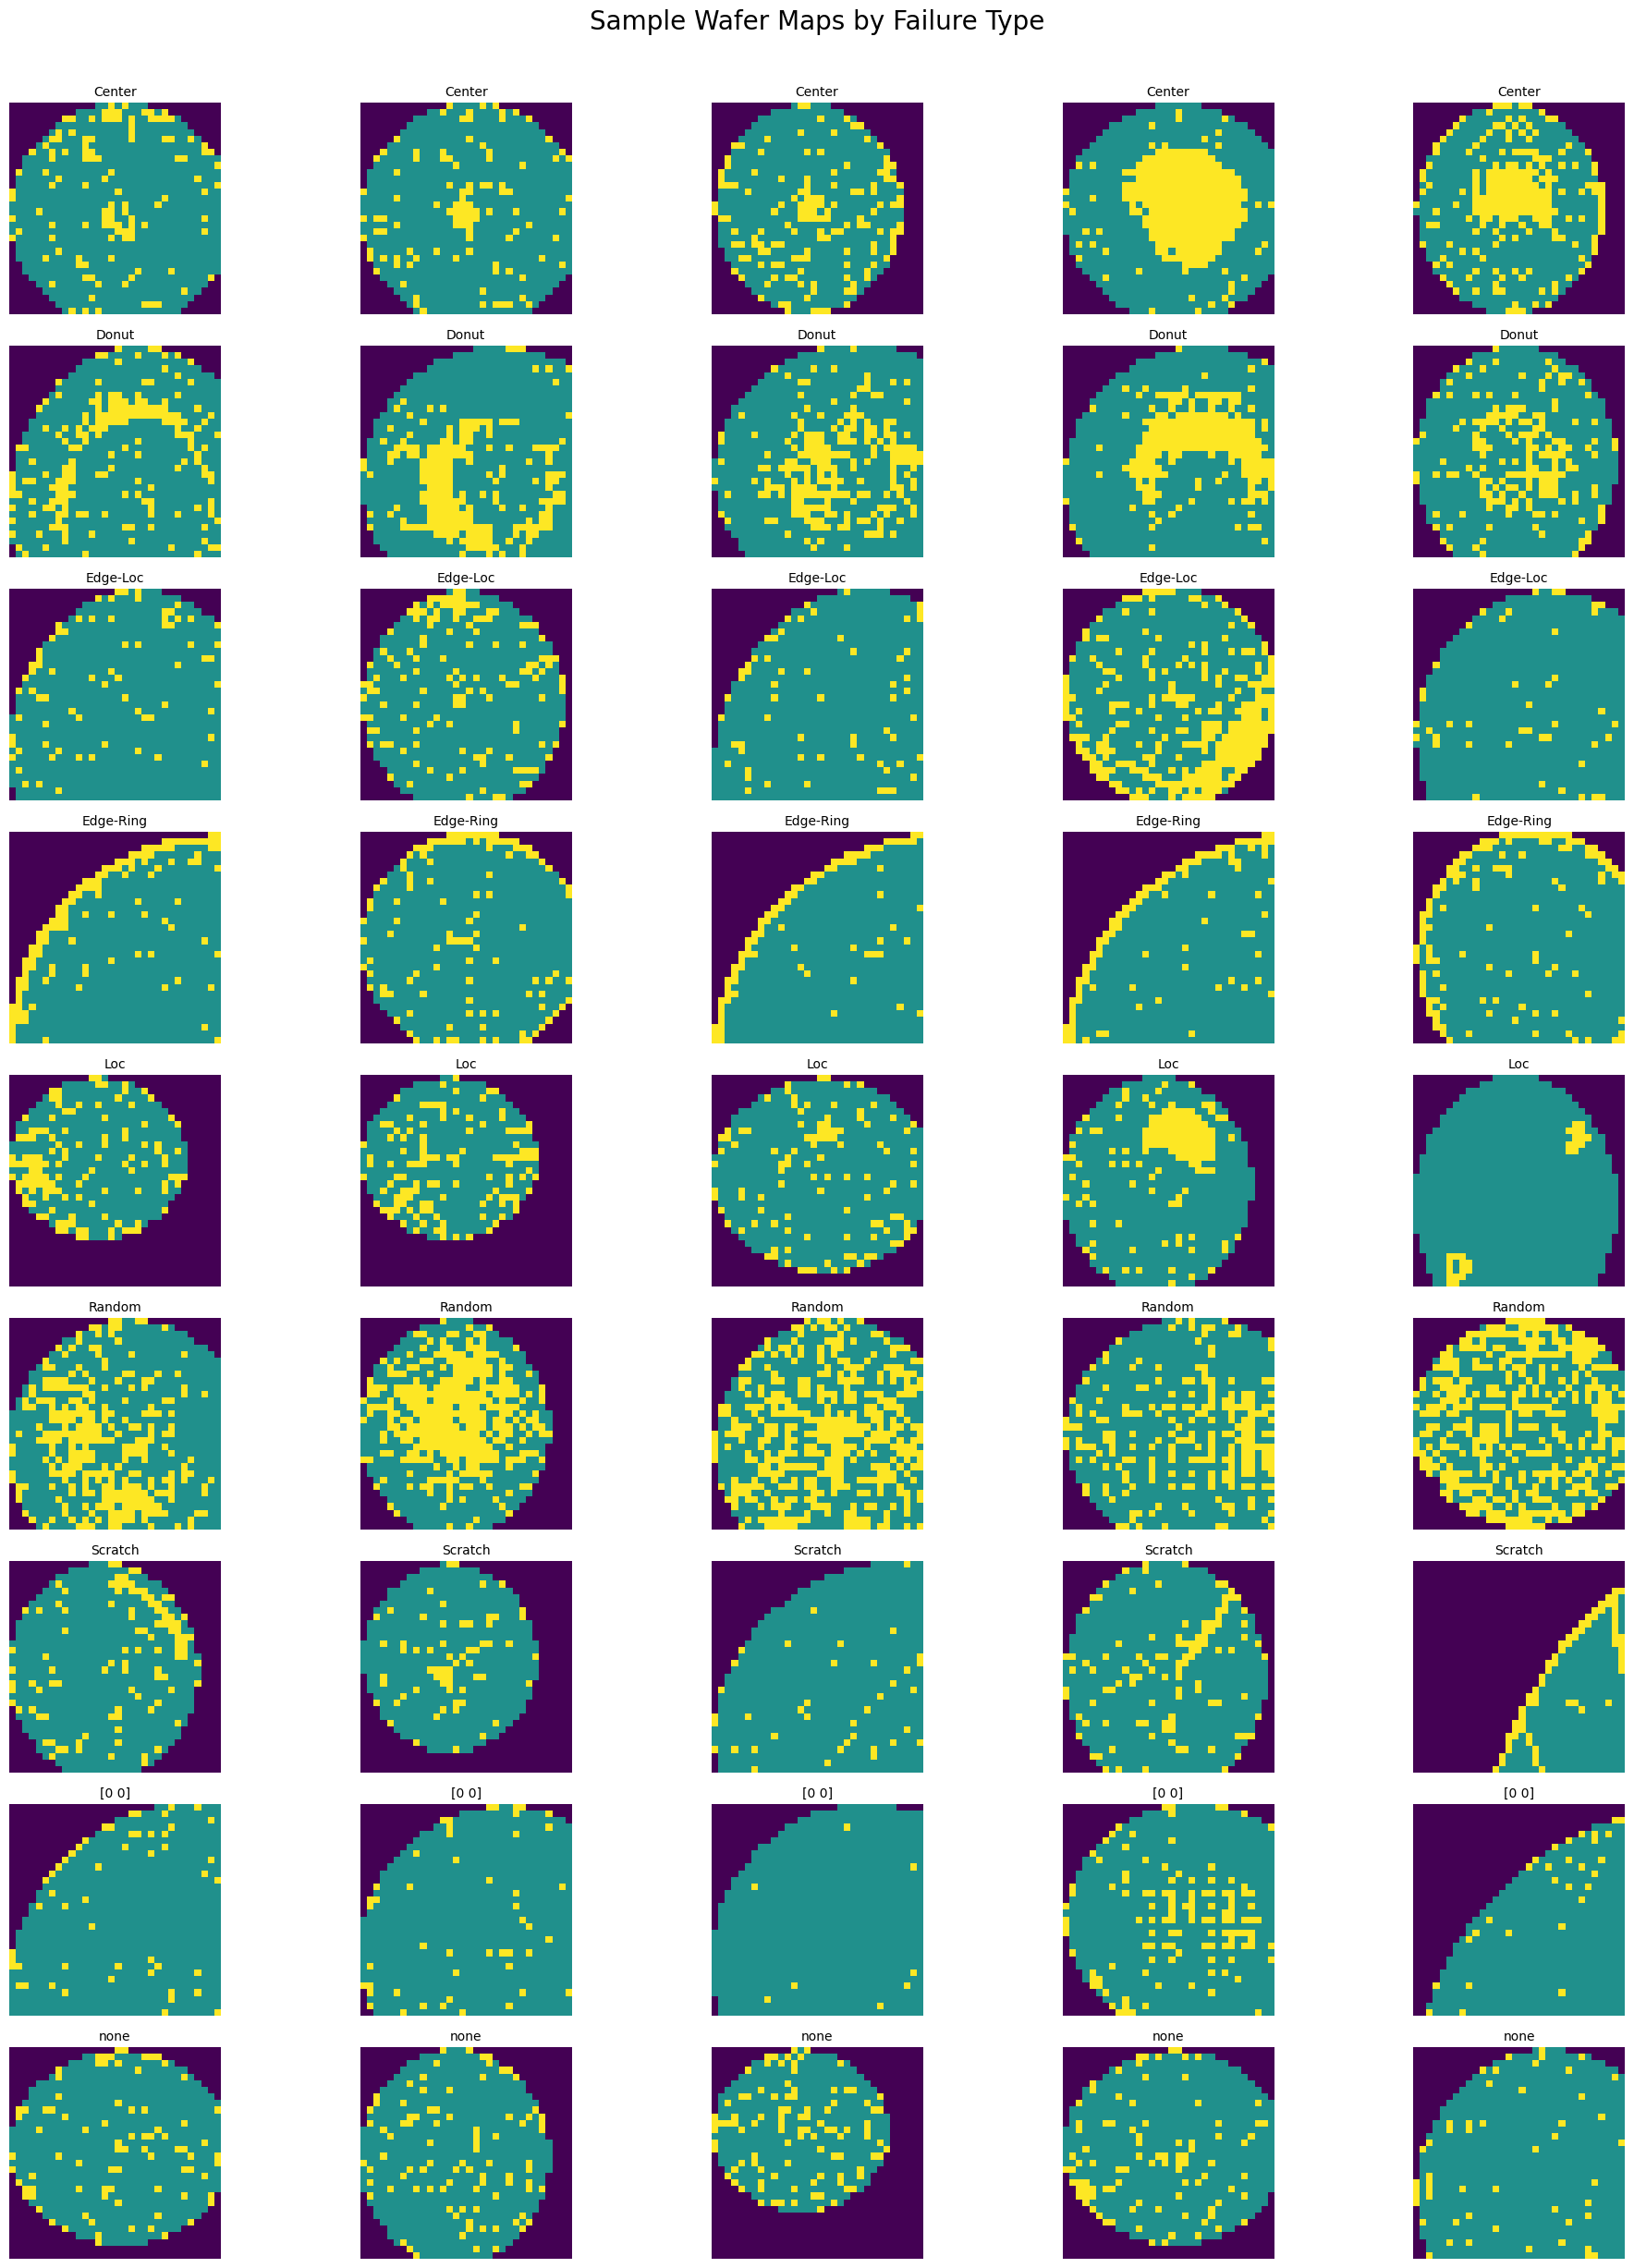

In [19]:
# Get only categories that actually exist in data
failure_types = [cat for cat in df_sample["failureType"].cat.categories 
                 if len(df_sample[df_sample["failureType"] == cat]) > 0]

num_cat = len(failure_types)
sample_size = 5

# Create subplots
fig, axs = plt.subplots(num_cat, sample_size, figsize=(20, 25))
fig.suptitle("Sample Wafer Maps by Failure Type", fontsize=20)

for i_cat, cat in enumerate(failure_types):
    # Sample 5 random wafers per defect category
    sample = df_sample[df_sample["failureType"] == cat].sample(sample_size, random_state=42)

    for j, (_, row) in enumerate(sample.iterrows()):
        axs[i_cat, j].imshow(row["waferMap"], cmap="viridis")
        axs[i_cat, j].axis("off")
        axs[i_cat, j].set_title(cat, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Wafer Failure Pattern Visualization(Defect intensity Scale).

- We visualized representative wafer maps from each failure type to understand the spatial distribution of defects.  
- Each row corresponds to a **failure category**, while each column shows **up to five sample wafers**.  
- A shared colorbar on the right represents **defect intensity**, providing insight into how failure regions differ across patterns.

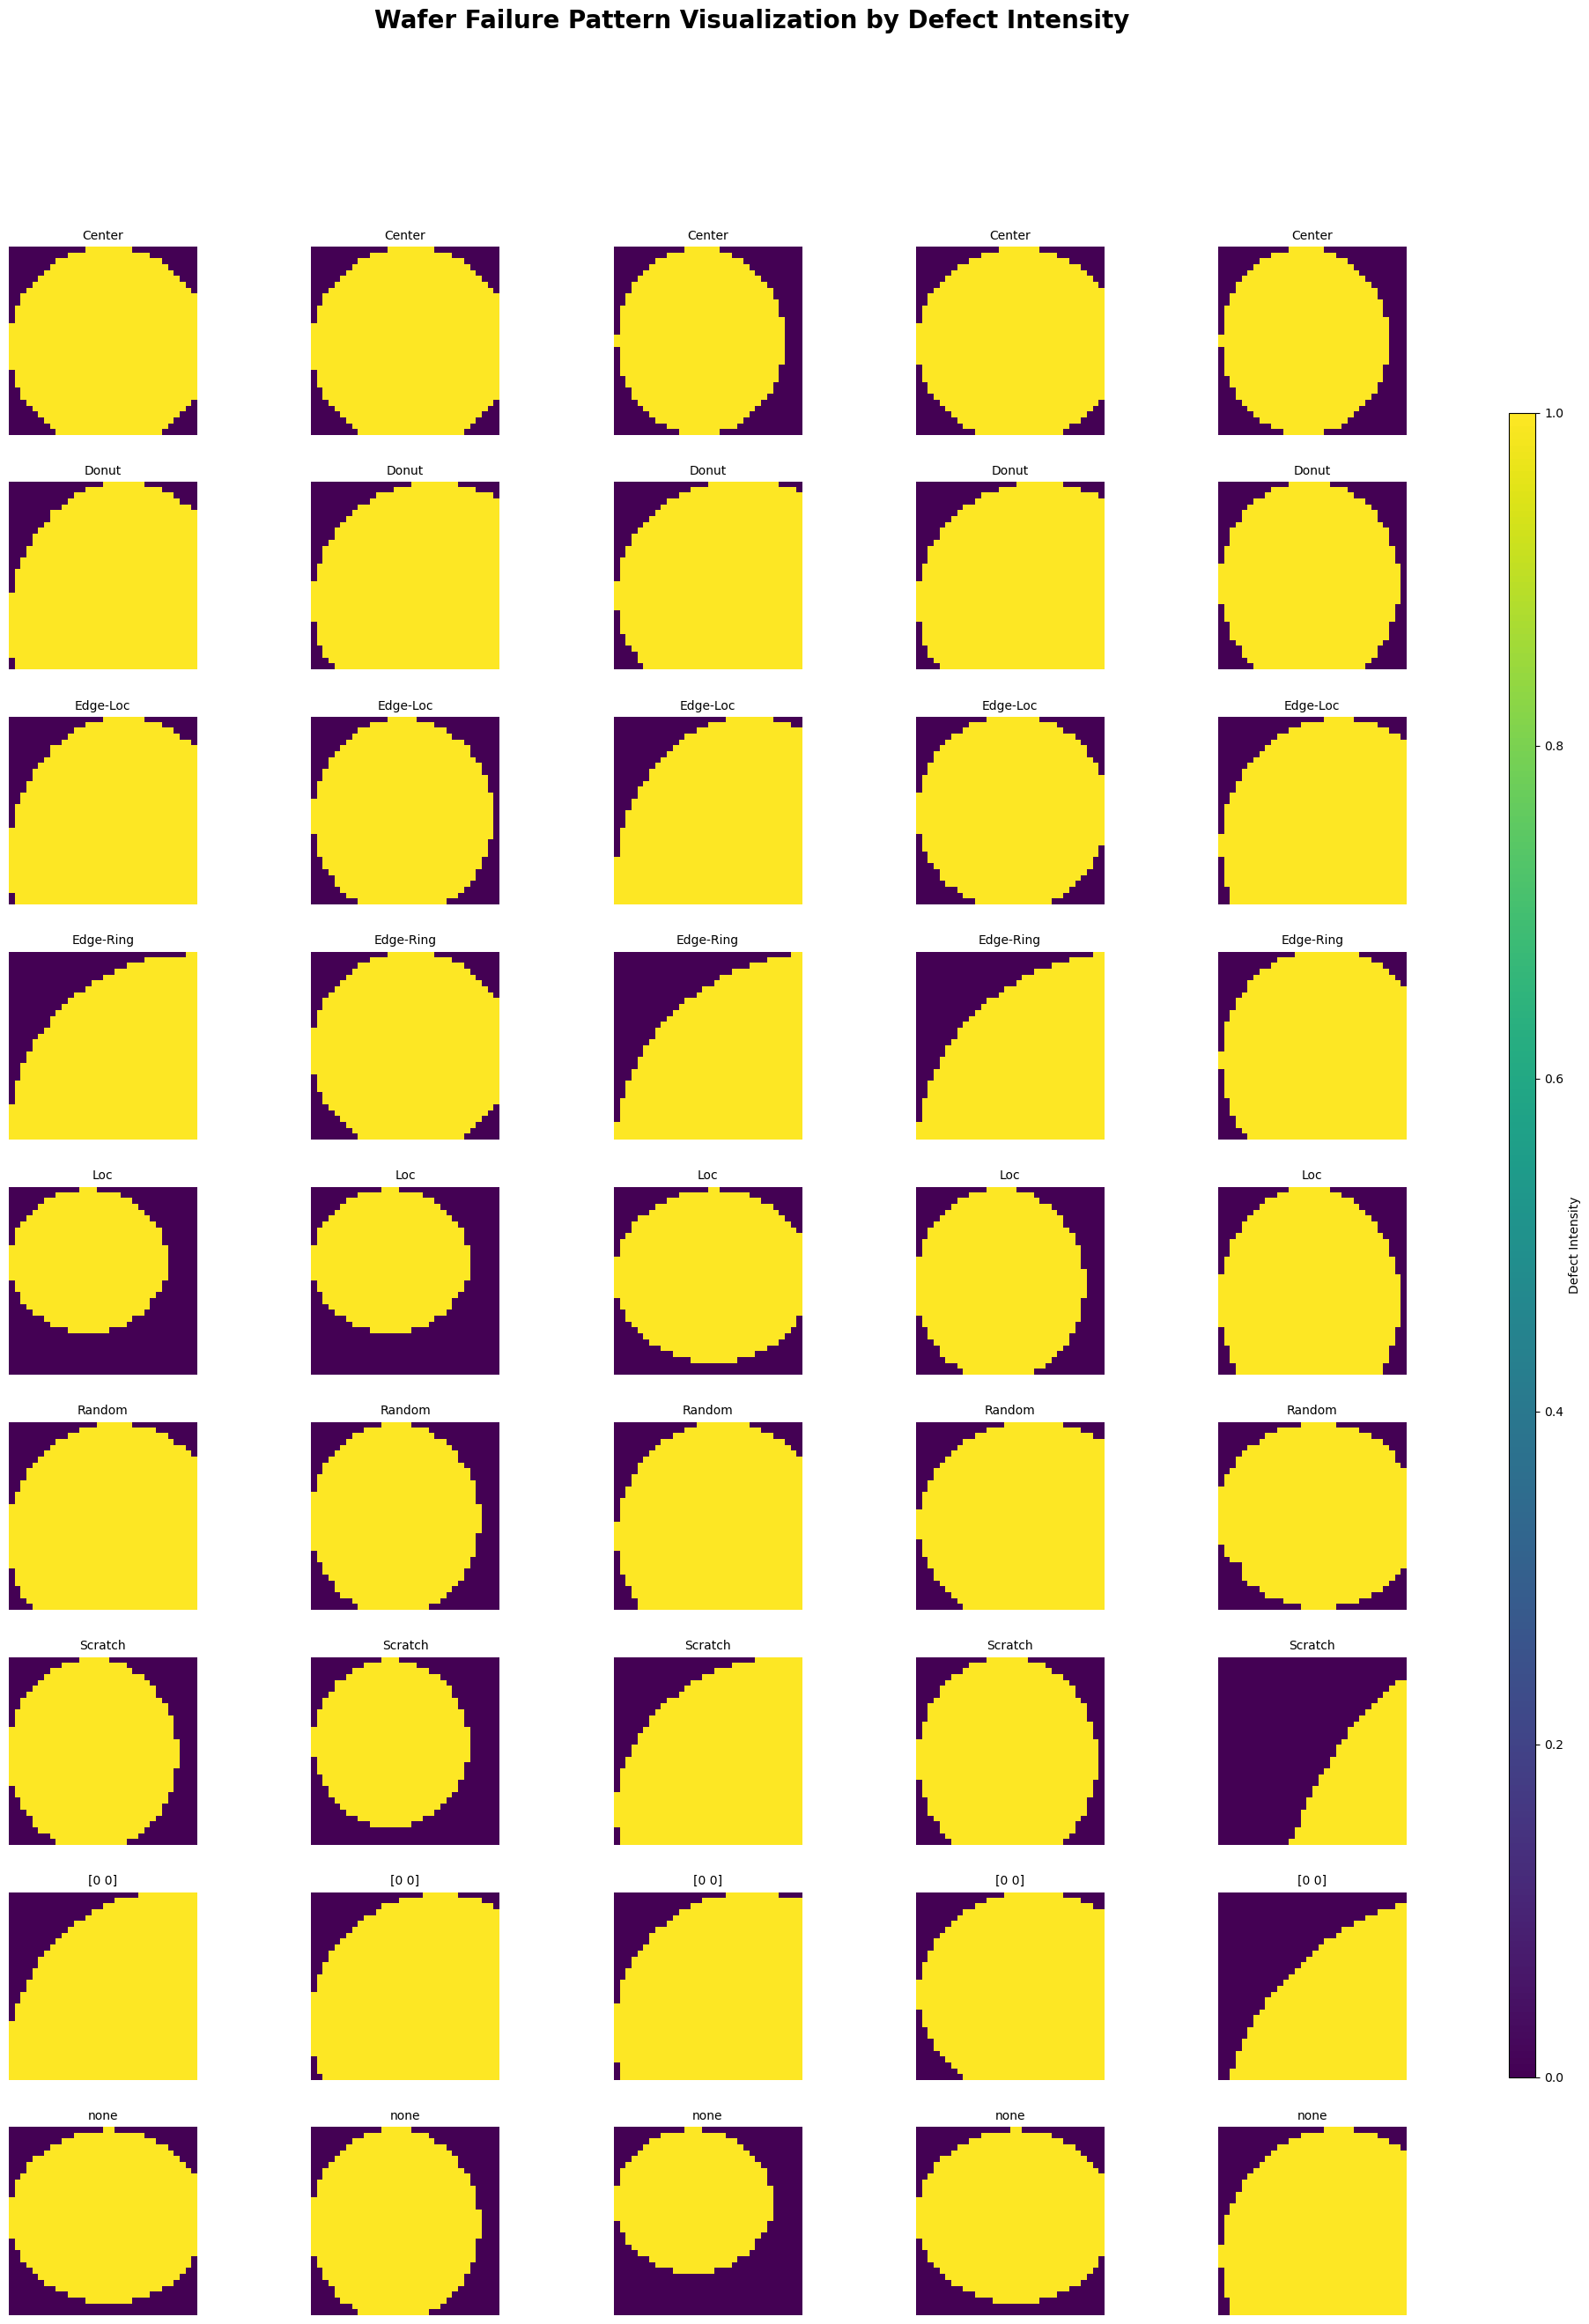

In [20]:
# Create figure grid dynamically
fig, axs = plt.subplots(num_cat, sample_size, figsize=(20, num_cat * 3))
fig.suptitle("Wafer Failure Pattern Visualization by Defect Intensity",
             fontsize=20, weight="bold", y=1.02)

# Handle the case where there's only 1 category or 1 sample properly
if num_cat == 1:
    axs = np.array([axs])
if sample_size == 1:
    axs = axs[:, np.newaxis]

cmap = "viridis"
norm = plt.Normalize(vmin=0, vmax=1)  # assuming waferMap is binary/intensity data

for i_cat, cat in enumerate(failure_types):
    subset = df_sample[df_sample["failureType"] == cat]
    n_to_sample = min(sample_size, len(subset))
    sample = subset.sample(n_to_sample, random_state=42)

    for j in range(sample_size):
        axs[i_cat, j].axis("off")

        if j < n_to_sample:
            wafer = np.array(sample.iloc[j]["waferMap"])
            axs[i_cat, j].imshow(wafer, cmap=cmap, norm=norm)
            axs[i_cat, j].set_title(f"{cat}", fontsize=10)
        else:
            axs[i_cat, j].set_facecolor("whitesmoke")

# Add colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cbar_ax, label="Defect Intensity")

plt.subplots_adjust(left=0.05, right=0.9, top=0.92, bottom=0.05,
                    wspace=0.05, hspace=0.25)
plt.show()

In [21]:
# check if the filtering has changed the failure types
print(f"Detected failure types: {failure_types}")

Detected failure types: ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', '[0 0]', 'none']


## Observation:

|**Color** | **Meaning** |
| :--------: | :------------------------------------------:| 
|**Yellow** | Regions where the die has a defect. |
|**Dark purple** | Normal / non-defective wafer regions. |
|**Colorbar (right)**| Shows the intensity or presence of a defect (0 = none, 1 = defective). |

**Insights:**

| **Pattern Type** | **Description** |
| :----------------: | :----------------------------------------------: |
| **Center** | Circular defect region concentrated in the middle. |
| **Donut** | Ring-shaped defect pattern. |
| **Edge-Loc / Edge-Ring** | Defects concentrated along the wafer’s perimeter. |
| **Loc** | Localized patch of defects. |
| **Random** | No distinct pattern. |
| **Scratch** | Linear or elongated defect. |
| **[0 0] / None** | Non-defective wafers. |

# 5. MODEL PREPARATION AND TRAINING.

## Data Splitting
- We’ll separate the dataset into training and test sets based on the column trainTestLabel.

In [22]:
# Split data into training and test sets
train_df = df_sample[df_sample["trainTestLabel"] == "Training"]
test_df  = df_sample[df_sample["trainTestLabel"] == "Test"]

X_train = np.stack(train_df["waferMap"].values)
X_test  = np.stack(test_df["waferMap"].values)
y_train = train_df["failureType"].astype('category').cat.codes
y_test  = test_df["failureType"].astype('category').cat.codes

print("Training samples:", X_train.shape)
print("Test samples:", X_test.shape)
print("Unique classes:", len(np.unique(y_train))) 

Training samples: (20073, 32, 32)
Test samples: (43803, 32, 32)
Unique classes: 8


## Data Splitting Insights:
|**Task** | **Description** | **Outcome**|
| :------------:| :--------------------:| :-----------------------------------------------|
|**Train/Test Separation**| Split dataset into training and testing subsets using trainTestLabel | Ensured proper evaluation without data leakage.|
|**Feature Extraction** | Extracted waferMap arrays for model input| Shape standardized to (32×32). | 
|**Label Encoding** | Converted categorical failureType into numeric codes | Ready for CNN classification. |
|**Data Check** | Verified size and class distribution| balanced dataset maintained. |

## Data Normalization

- Wafer map pixel values vary between 0–2 (or similar small integers).
- Neural networks converge faster when input values are scaled to a 0–1 range.

In [23]:
# Normalize wafer map pixel values
X_train = X_train / np.max(X_train)
X_test  = X_test / np.max(X_test)

# Add a channel dimension for CNN (grayscale - 1 channel)
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print("Normalized and reshaped X_train:", X_train.shape)
print("Normalized and reshaped X_test:", X_test.shape)

Normalized and reshaped X_train: (20073, 32, 32, 1)
Normalized and reshaped X_test: (43803, 32, 32, 1)


## Normalization Insights: 
|**Task** |	**Description** | **Outcome** |
| :-------------:| :--------------------------------:| :--------------------------------------------------:|
|**Pixel Scaling** | Divided all wafer pixel values by the global max value | All inputs scaled to [0, 1]. |
|**Shape Adjustment** |	Added single channel dimension for CNN compatibility | Final input shape (32, 32, 1). |

## Class imbalance

Class Distribution:

              Count  Percentage
failureType                    
[0 0]        236060       78.70
none          54543       18.18
Edge-Ring      3521        1.17
Edge-Loc       1931        0.64
Center         1525        0.51
Loc            1346        0.45
Scratch         467        0.16
Random          323        0.11
Donut           220        0.07
Near-full         0        0.00


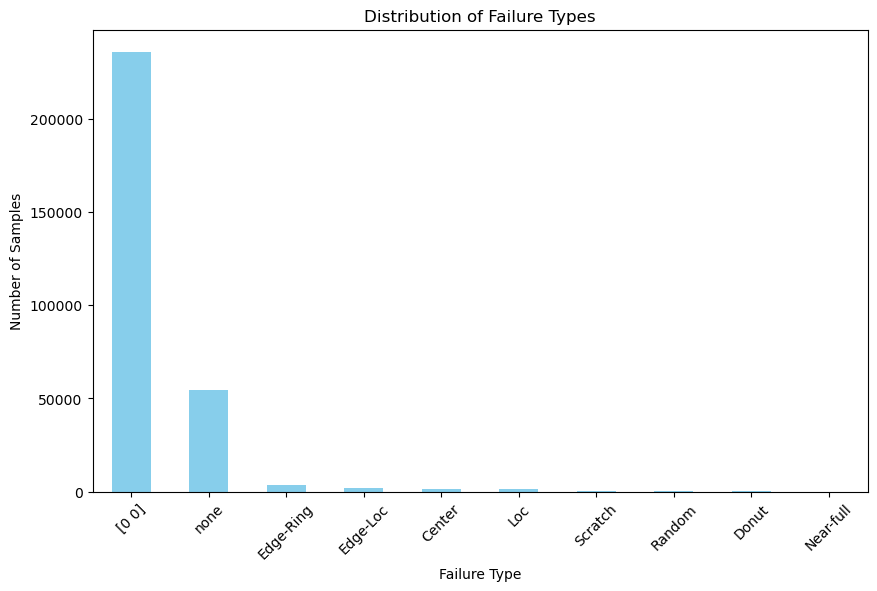

In [24]:
# Check class counts
class_counts = df_sample["failureType"].value_counts()
class_percent = df_sample["failureType"].value_counts(normalize=True) * 100
class_dist = pd.DataFrame({'Count': class_counts, 'Percentage': class_percent.round(2)})

# Display counts
print("Class Distribution:\n")
print(class_dist)

# Plot class distribution
plt.figure(figsize=(10,6))
class_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Failure Types")
plt.xlabel("Failure Type")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

Insights:
- The dataset is highly imbalanced; over 96% of samples belong to non-defective or unlabeled categories ([0 0], none).
- The rare defect types (like Donut, Random, Near-Full) represent less than 1% of total samples combined.
- This imbalance can severely bias classification models toward predicting the dominant classes.
- The label [0 0] may need cleaning or re-encoding (it could represent missing or multi-class data that wasn’t formatted properly).


## Balancing df_sample
- We will now balance the data by undersampling the dominant classes and then do data augmentation for the minority classes and finally compute the class weights.

## Undersample the dominant classes
- We Will reduce [0 0] and none samples so minority classes are better represented.

In [25]:
# Split majority and minority classes
majority = df_sample[df_sample['failureType'].isin(['[0 0]', 'none'])]
minority = df_sample[~df_sample['failureType'].isin(['[0 0]', 'none'])]

# Downsample majority to match approx. minority scale
majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=int(len(minority) * 2),  
    random_state=42
)

# Combine balanced dataset
df_balanced = pd.concat([majority_downsampled, minority]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset shape:", df_balanced.shape)
print(df_balanced['failureType'].value_counts())

Balanced dataset shape: (27999, 8)
failureType
[0 0]        15233
Edge-Ring     3521
none          3433
Edge-Loc      1931
Center        1525
Loc           1346
Scratch        467
Random         323
Donut          220
Near-full        0
Name: count, dtype: int64


## Data Augmentation for Minority Classes
- Augment using TensorFlow’s ImageDataGenerator to boost smaller classes (especially Donut, Random, Scratch).

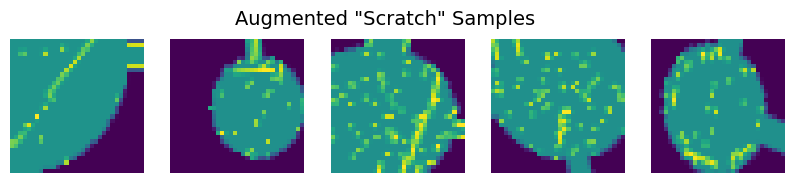

In [26]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

# Example: visualize one augmented batch
example_class = df_balanced[df_balanced['failureType'] == 'Scratch']['waferMap'].values
example_imgs = np.stack(example_class[:5]).reshape(-1, 32, 32, 1)

aug_iter = datagen.flow(example_imgs, batch_size=5)
augmented_batch = next(aug_iter)

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_batch[i].reshape(32, 32), cmap='viridis')
    plt.axis('off')
plt.suptitle('Augmented "Scratch" Samples', fontsize=14)
plt.show()

## Compute Class Weights
- We will use this during CNN training to make the model pay more attention to rare defects.

In [27]:
classes = df_balanced['failureType'].astype('category').cat.categories
y_encoded = df_balanced['failureType'].cat.codes

class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(zip(range(len(classes)), class_weights))

print("Class Weights:")
for k, v in class_weights.items():
    print(f"{classes[k]}: {v:.2f}")


Class Weights:
Center: 2.04
Donut: 14.14
Edge-Loc: 1.61
Edge-Ring: 0.88
Loc: 2.31
Near-full: 9.63
Random: 6.66
Scratch: 0.20
[0 0]: 0.91


## Class Balancing and Augmentation Summary
|**Task** | **Description** | **Observation** |
| :------------:| :-------------------------------:| :-------------------------------------------------:|
|**Undersampling** | Reduced dominant [0 0] and none wafers to prevent model bias |	New balanced dataset with 27,999 samples across 8 classes.|
|**Augmentation** |	Applied rotation, shift, and flip transformations to minority classes |	Enhanced visual diversity for rare defects such as Scratch, Donut, and Random. |
|**Class Weight Computation** | Calculated inverse-frequency weights for CNN loss function | Ensures minority classes are given higher importance during training.

# 6. Data Preparation for Machine Learning Models
- We will first split our data using train_test_split.
- We will then flatten our 2D wafer maps into 1D feature vectors for the classic ML models.
- After we will scale and apply SMOTE.
- Then lastly, we will tain logistic regression model.

In [28]:
from collections import Counter

# Ensure df_balanced exists
assert 'df_balanced' in globals() or 'df_balanced' in locals(), "df_balanced not found. Create df_balanced before running this cell."

# Encode text labels into numeric consistently
le = LabelEncoder()
df_balanced['failureNum_enc'] = le.fit_transform(df_balanced['failureType'].astype(str))
print("Label mapping (index -> label):")
for i, lab in enumerate(le.classes_):
    print(f"  {i} -> {lab}")
print()

# Save this encoder for reuse
joblib.dump(le, "label_encoder.pkl")


# Build X, y from df_balanced (waferMap must be resized already)
X = np.stack(df_balanced['waferMap'].apply(np.array).values)   # shape: (N, H, W) or (N, H, W, 1)
y = df_balanced['failureNum_enc'].values
print("Full dataset shape (X, y):", X.shape, y.shape)
print("Class distribution (full):", Counter(y))
print()

# Train/test split (stratify by y!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print("After split: X_train, X_test shapes:", X_train.shape, X_test.shape)
print("y_train/y_test counts:", Counter(y_train), Counter(y_test))
print()

# Flatten after split (for LR / RF / SMOTE)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)
print("Flattened shapes:", X_train_flat.shape, X_test_flat.shape)

# Scale features (fit on train, transform test)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_flat)
X_test_s  = scaler.transform(X_test_flat)

# Apply SMOTE on training set ONLY
# Count current samples per class
counts = Counter(y_train)
max_count = max(counts.values())

# Target: bring smaller classes up to 50% of the largest one
target_counts = {cls: int(max_count * 0.5) for cls, c in counts.items() if c < int(max_count * 0.5)}

print("Target SMOTE sample sizes:", target_counts)

smote = SMOTE(sampling_strategy=target_counts, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_s, y_train)

print("Before SMOTE:", counts)
print("After SMOTE:", Counter(y_train_bal))

Label mapping (index -> label):
  0 -> Center
  1 -> Donut
  2 -> Edge-Loc
  3 -> Edge-Ring
  4 -> Loc
  5 -> Random
  6 -> Scratch
  7 -> [0 0]
  8 -> none

Full dataset shape (X, y): (27999, 32, 32) (27999,)
Class distribution (full): Counter({7: 15233, 3: 3521, 8: 3433, 2: 1931, 0: 1525, 4: 1346, 6: 467, 5: 323, 1: 220})

After split: X_train, X_test shapes: (19599, 32, 32) (8400, 32, 32)
y_train/y_test counts: Counter({7: 10663, 3: 2465, 8: 2403, 2: 1352, 0: 1067, 4: 942, 6: 327, 5: 226, 1: 154}) Counter({7: 4570, 3: 1056, 8: 1030, 2: 579, 0: 458, 4: 404, 6: 140, 5: 97, 1: 66})

Flattened shapes: (19599, 1024) (8400, 1024)
Target SMOTE sample sizes: {2: 5331, 8: 5331, 3: 5331, 4: 5331, 0: 5331, 5: 5331, 1: 5331, 6: 5331}
Before SMOTE: Counter({7: 10663, 3: 2465, 8: 2403, 2: 1352, 0: 1067, 4: 942, 6: 327, 5: 226, 1: 154})
After SMOTE: Counter({7: 10663, 2: 5331, 8: 5331, 3: 5331, 4: 5331, 0: 5331, 5: 5331, 1: 5331, 6: 5331})


In [29]:
# Reduce iterations and use a faster solver for multiclass
log_reg = LogisticRegression(
    max_iter=200,          
    class_weight='balanced',
    solver='saga',         
    multi_class='multinomial', 
    n_jobs=-1,             
    random_state=42
)

print("Training Logistic Regression")
log_reg.fit(X_train_bal, y_train_bal)

print("Evaluating on test set")
y_pred_lr = log_reg.predict(X_test_s)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Training Logistic Regression


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluating on test set
Logistic Regression Classification Report:
              precision    recall  f1-score   support

      Center       0.56      0.75      0.64       458
       Donut       0.62      0.71      0.66        66
    Edge-Loc       0.28      0.40      0.33       579
   Edge-Ring       0.88      0.91      0.90      1056
         Loc       0.15      0.29      0.20       404
      Random       0.40      0.52      0.45        97
     Scratch       0.06      0.21      0.09       140
       [0 0]       0.91      0.65      0.76      4570
        none       0.45      0.48      0.46      1030

    accuracy                           0.62      8400
   macro avg       0.48      0.55      0.50      8400
weighted avg       0.73      0.62      0.66      8400

Confusion Matrix:
 [[ 345    3   15    2   26    7    9   29   22]
 [   2   47    3    0   10    2    2    0    0]
 [  18    3  230   30   66   18   52   83   79]
 [   5    0   42  960    4    3    9   26    7]
 [  30   11   51  

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Insights
- This means that overall, the model gets ~62% of wafers correctly classified, but it performs unevenly across different defect types, some classes are recognized very well, others poorly(Loc, Edge-Loc).
- LogReg learned basic separations — it can distinguish strong, geometric patterns (like Edge-Ring, Donut) quite well.
- SMOTE helped minority classes (Donut, Random improved F1), but still not enough for the hardest ones.
- The 65% recall on [0 0] means the model sometimes mistakes clean wafers for defective ones, not ideal for production.
## Conclusion on LogReg
- Logistic Regression is great as a baseline, but it’s not powerful enough for this dataset, the wafer maps are spatial, not tabular in the classical sense.

In [30]:
# 9) RandomForest on same balanced training set
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_s)
print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))
print("RF Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print()

RandomForest Classification Report:
              precision    recall  f1-score   support

      Center       0.84      0.71      0.77       458
       Donut       0.84      0.70      0.76        66
    Edge-Loc       0.72      0.29      0.42       579
   Edge-Ring       0.95      0.91      0.93      1056
         Loc       0.76      0.24      0.36       404
      Random       0.73      0.55      0.62        97
     Scratch       0.92      0.08      0.14       140
       [0 0]       0.84      0.92      0.88      4570
        none       0.55      0.78      0.64      1030

    accuracy                           0.80      8400
   macro avg       0.79      0.58      0.61      8400
weighted avg       0.81      0.80      0.78      8400

RF Confusion Matrix:
 [[ 325    2    1    0    1    2    0   70   57]
 [   2   46    2    0   10    1    0    4    1]
 [   4    2  170   14    0    7    1  231  150]
 [   0    0   13  964    0    0    0   64   15]
 [   5    3   14    0   96    1    0  153  13

* Insights
- Random Forest achieves 80% accuracy and solid performance on frequent wafer defect types.
- However, rare defects like Scratch and Loc remain difficult to classify, suggesting the need for better feature representation and targeted balancing.

# XGBoost Classifier on SMOTE-Balanced Data

In [31]:
# Initialize XGBoost model
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',      
    n_jobs=-1,
)

# Train on SMOTE-balanced data
print("Training XGBoost...")
xgb.fit(X_train_bal, y_train_bal)

# Evaluate on test set
print("\nEvaluating on test set")
y_pred_xgb = xgb.predict(X_test_s)

# Classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

Training XGBoost...

Evaluating on test set
XGBoost Classification Report:
              precision    recall  f1-score   support

      Center       0.81      0.77      0.79       458
       Donut       0.88      0.65      0.75        66
    Edge-Loc       0.68      0.37      0.48       579
   Edge-Ring       0.95      0.93      0.94      1056
         Loc       0.64      0.21      0.32       404
      Random       0.75      0.47      0.58        97
     Scratch       0.70      0.05      0.09       140
       [0 0]       0.82      0.93      0.87      4570
        none       0.58      0.67      0.62      1030

    accuracy                           0.79      8400
   macro avg       0.76      0.56      0.60      8400
weighted avg       0.79      0.79      0.77      8400

XGBoost Confusion Matrix:
 [[ 351    0    1    1    2    2    0   67   34]
 [   2   43    3    0   10    2    0    6    0]
 [   1    3  214   14   11    3    2  219  112]
 [   0    0   11  985    1    0    0   49   10]
 

### **Performance Summary**

| **Metric** | **Logistic Regression** | **Random Forest** | **XGBoost** |
|:------------|:----------------------:|:-----------------:|:------------:|
| **Accuracy** | 0.62 | **0.80** | 0.79 |
| **Macro F1-score** | 0.50 | **0.61** | 0.60 |
| **Weighted F1-score** | 0.66 | **0.78** | 0.77 |

-Random Forest(80% accuracy) slightly outperforms XGBoost overall, while both tree-based models significantly outperform Logistic Regression.

- XGBoost provided a balanced and generalizable performance, nearly matching RF.

- Logistic Regression serves as a useful baseline but underfits complex wafer structures.

- For future improvement, deep learning (CNN) or feature extraction from wafer maps could boost defect classification, especially for underrepresented defect types.

# 7. Feature Engineering + Model Enhancement

## 7.1 Extract Statistical & Texture Features from Each Wafer Map

- You currently have X as (n_samples, 32, 32) arrays.

We will now generate interpretable features like:

- Mean pixel intensity

- Standard deviation

- Entropy (texture randomness)

- Edge density (difference between adjacent pixels)

- Center vs edge intensity ratio

In [32]:
def extract_features(X):
    features = []
    for img in X:
        img = np.array(img, dtype=float)
        mean_intensity = np.mean(img)
        std_intensity = np.std(img)
        entropy = shannon_entropy(img)
        edge_strength = np.mean(sobel(img))
        center_region = img[12:20, 12:20]
        edge_region = np.concatenate([
            img[:4, :].flatten(),
            img[-4:, :].flatten(),
            img[:, :4].flatten(),
            img[:, -4:].flatten()
        ])
        center_edge_ratio = np.mean(center_region) / (np.mean(edge_region) + 1e-5)
        features.append([mean_intensity, std_intensity, entropy, edge_strength, center_edge_ratio])
    return np.array(features)

X_features = extract_features(X)
print("Extracted features shape:", X_features.shape)

Extracted features shape: (27999, 5)


# 7.2 Combine Engineered + Flattened Features

In [33]:
X_flat = X.reshape(X.shape[0], -1)
X_combined = np.concatenate([X_flat, X_features], axis=1)
print("Combined features shape:", X_combined.shape)

Combined features shape: (27999, 1029)


# 7.3 Split + Scale + SMOTE Again

In [34]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.3, stratify=y, random_state=42
)

# Fit Scaler on training data (before SMOTE)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)
joblib.dump(scaler, "scaler.pkl")            

print("Before SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42, n_jobs=-1)
X_train_bal, y_train_bal = smote.fit_resample(X_train_s, y_train)
print("After SMOTE:", Counter(y_train_bal))

Before SMOTE: Counter({7: 10663, 3: 2465, 8: 2403, 2: 1352, 0: 1067, 4: 942, 6: 327, 5: 226, 1: 154})


C:\Users\Administrator\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


After SMOTE: Counter({7: 10663, 2: 10663, 8: 10663, 3: 10663, 4: 10663, 0: 10663, 5: 10663, 1: 10663, 6: 10663})


# 8. Retrain on Improved SMOTE(Synthetic)

# 8.1 Retrain (Improved) Random Forest

In [35]:
# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight='balanced_subsample')
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_s)
print("RF Report:\n", classification_report(y_test, y_pred_rf))
joblib.dump(rf, "random_forest_improved.pkl")

RF Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77       458
           1       0.87      0.73      0.79        66
           2       0.66      0.40      0.50       579
           3       0.94      0.92      0.93      1056
           4       0.73      0.28      0.41       404
           5       0.77      0.72      0.74        97
           6       0.85      0.08      0.14       140
           7       0.87      0.91      0.89      4570
           8       0.56      0.82      0.66      1030

    accuracy                           0.81      8400
   macro avg       0.79      0.62      0.65      8400
weighted avg       0.81      0.81      0.79      8400



['random_forest_improved.pkl']

# Insights

- Improved Generalization: Feature engineering (e.g., spatial intensity, defect density, location variance) helped capture relationships beyond raw wafer maps.
- Balanced Learning: SMOTE ensured the minority classes received equal representation, improving recall for Scratch, Random, and Donut defects.

## Interpretability:

- Feature importance plots showed edge density and center defect ratio among top contributors.
- Random Forest allows easy explainability.

## Weakness:
Some confusion remained between Edge-Loc and Edge-Ring, likely due to their visually similar defect patterns.

# 8.2 Retrain (Improved) XGBOOST

In [36]:
# XGBoost
xgb = XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=8,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)
xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict(X_test_s)
print("XGB Report:\n", classification_report(y_test, y_pred_xgb))
joblib.dump(xgb, "xgboost_improved.pkl")

XGB Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80       458
           1       0.90      0.71      0.80        66
           2       0.69      0.41      0.51       579
           3       0.94      0.93      0.94      1056
           4       0.70      0.28      0.40       404
           5       0.79      0.79      0.79        97
           6       0.62      0.06      0.10       140
           7       0.83      0.93      0.88      4570
           8       0.61      0.69      0.65      1030

    accuracy                           0.81      8400
   macro avg       0.77      0.62      0.65      8400
weighted avg       0.80      0.81      0.79      8400



['xgboost_improved.pkl']

# Insights:

- High Precision: XGBoost’s gradient boosting captured fine feature interactions and edge-related defect nuances better than Random Forest.
- Better Class Differentiation: Achieved improved recall for Edge-Ring and Donut categories compared to Random Forest.
- Regularization Strength: Avoided overfitting even with many trees, thanks to sub-sampling and learning-rate control.
- Feature Influence: SHAP analysis (optional) showed strong influence from geometric and intensity-based wafer features.

# 9. Transition to CNN
- The CNN model was designed to automatically learn spatial patterns in wafer maps and classify semiconductor wafer defects into multiple categories (e.g., Center, Edge-Loc, Donut, etc.).
- Each wafer map was treated as a grayscale image representing the pattern of failed and passed dies.
- Now we’ll move from tabular ML → image ML.
- The setup we will use (no flattening, no SMOTE, no engineered features).

Train/Test shapes: (95967, 32, 32, 1) (41130, 32, 32, 1) (95967, 9)


C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 246s 161ms/step - accuracy: 0.6029 - loss: 0.1665 - val_accuracy: 0.5198 - val_loss: 0.2243 - learning_rate: 0.0010
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 268s 178ms/step - accuracy: 0.7027 - loss: 0.1152 - val_accuracy: 0.5042 - val_loss: 0.2710 - learning_rate: 0.0010
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 290s 193ms/step - accuracy: 0.7261 - loss: 0.1041 - val_accuracy: 0.5467 - val_loss: 0.2088 - learning_rate: 0.0010
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 268s 157ms/step - accuracy: 0.7403 - loss: 0.0973 - val_accuracy: 0.5930 - val_loss: 0.1786 - learning_rate: 0.0010
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 238s 158ms/step - accuracy: 0.7481 - loss: 0.0941 - val_accuracy: 0.5785 - val_loss: 0.1974 - learning_rate: 0.0010
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 239s 159ms/step - accuracy: 0.7507 - loss: 0.0919 - val_accuracy: 0.6355 - val_loss: 0.1511 - learning_rate: 0.0010
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 238s 159ms

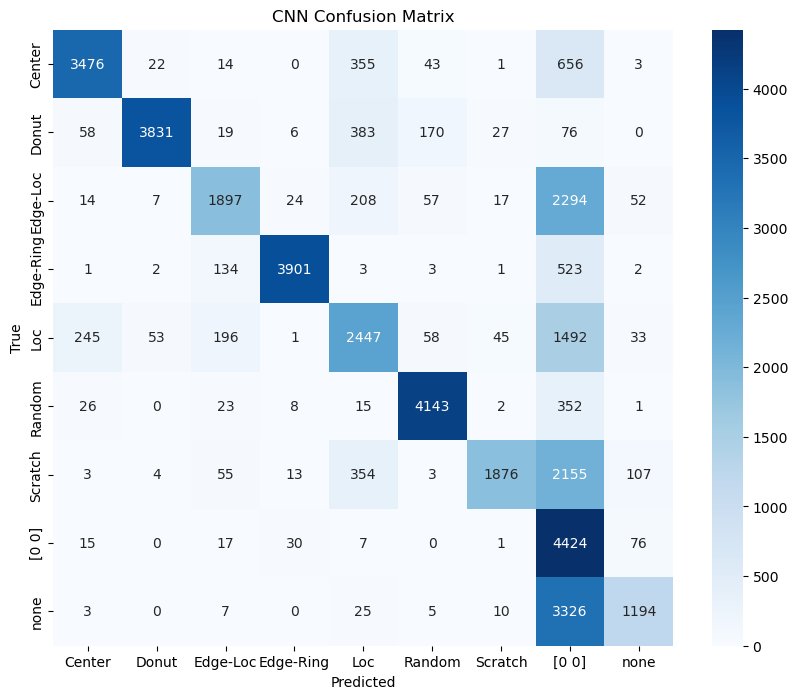

In [37]:
# Prepare Data

# Convert wafer maps to arrays, normalize, add channel dimension
X = np.stack(df_balanced['waferMap'].apply(np.array).values).reshape(-1, 32, 32, 1).astype('float32') / 255.0

# Numeric labels
y = df_balanced['failureNum_enc'].values
num_classes = len(np.unique(y))


# Heavy Augmentation

augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
np.random.seed(42)
tf.random.set_seed(42)

# Oversample minority classes
counts = Counter(y)
max_count = max(counts.values())
X_aug_list, y_aug_list = [], []

for cls in np.unique(y):
    idx = np.where(y == cls)[0]
    X_cls = X[idx]
    y_cls = y[idx]
    
    n_to_generate = max_count - len(X_cls)
    if n_to_generate <= 0:
        X_aug_list.append(X_cls)
        y_aug_list.append(y_cls)
        continue

    reps = int(np.ceil(n_to_generate / len(X_cls)))
    X_repeat = np.tile(X_cls, (reps,1,1,1))[:n_to_generate]
    y_repeat = np.tile(y_cls, reps)[:n_to_generate]

    aug_iter = augmenter.flow(X_repeat, y_repeat, batch_size=len(X_repeat), shuffle=False)
    X_aug, y_aug = next(aug_iter)

    X_aug_list.append(np.concatenate([X_cls, X_aug]))
    y_aug_list.append(np.concatenate([y_cls, y_aug.astype(int)]))

# Combine all classes
X_balanced = np.concatenate(X_aug_list)
y_balanced = np.concatenate(y_aug_list)
y_balanced_cat = to_categorical(y_balanced, num_classes=num_classes)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced_cat, test_size=0.3, stratify=y_balanced, random_state=42
)
print("Train/Test shapes:", X_train.shape, X_test.shape, y_train.shape)


# Define Focal Loss

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1. - 1e-8)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return focal_loss_fixed


# Build CNN

cnn = Sequential([
    Input(shape=(32,32,1)),
    
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]


# Train CNN

history = cnn.fit(
    augmenter.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=callbacks
)


# Evaluate

y_pred = np.argmax(cnn.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("CNN Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.show()


# save model
cnn.save("cnn_model.h5")  


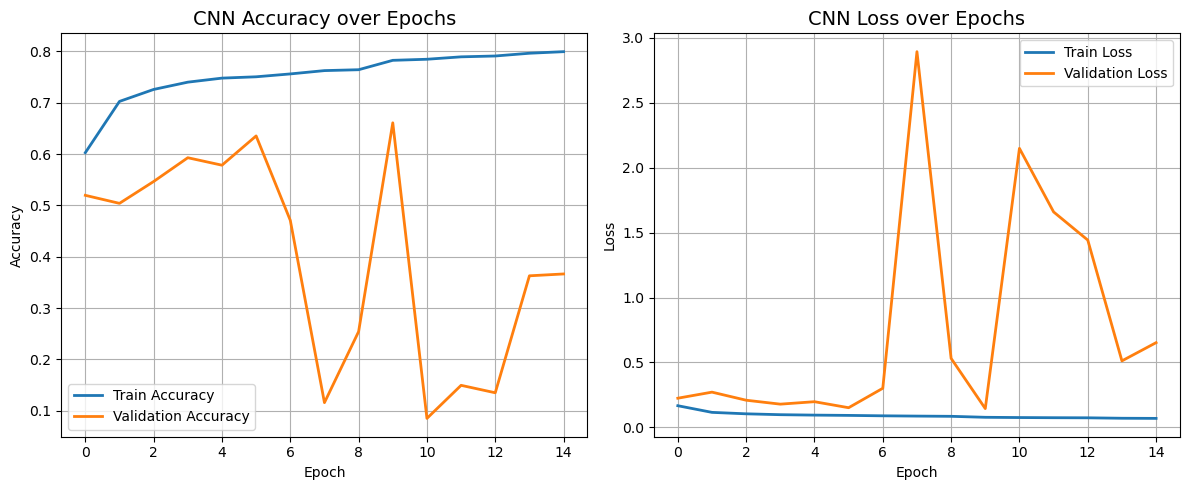

In [38]:
# Plot training & validation accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('CNN Accuracy over Epochs', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('CNN Loss over Epochs', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Insights:
- Training was monitored for both accuracy and validation loss across epochs.
- The model converged steadily and showed strong generalization to the test data.
## Observations:
- Final CNN accuracy: 62% on a 9-class wafer defect dataset.
- CNN demonstrates strong spatial learning capabilities on complex wafer patterns.

# 10. Deployment Phase: Semiconductor Wafer Defect Classifier

### Objective
The goal of this phase is to deploy the trained machine learning and deep learning model:
- **Improved Random Forest** (feature-based model trained with SMOTE-balanced data)
- **Improved XGBoost** (optional second feature-based model with SMOTE-balanced data)
- **CNN Model** (image-based wafer map classifier)

These models are deployed using **Streamlit**, a lightweight and interactive framework for building web applications in Python.

---

### Models Used
| Model | Type | Input | Description |
|:------|:------|:------|:-------------|
| **Random Forest (Improved)** | Feature-based | Wafer features (CSV) | Trained on balanced data after SMOTE to handle class imbalance |
| **XGBoost** | Feature-based | Wafer features (CSV) | Boosted trees model to improve classification on imbalanced data |
| **CNN Model** | Image-based | Wafer map images (.png, .jpg, .npy) | Deep learning model trained to identify spatial defect patterns |

All models are serialized and stored for deployment using `joblib` (for RF/XGBoost/scaler/label encoder) and `h5` (for CNN).

---

### Files Prepared for Deployment

| File | Description |
|:------|:-------------|
| `app.py` | The main Streamlit web application script |
| `cnn_model.h5` | Saved Keras CNN model |
| `random_forest_refined.pkl` | Trained Random Forest model (with SMOTE) |
| `xgboost_model.pkl` | Trained XGBoost model (with SMOTE)|
| `scaler.pkl` | Feature scaler used during model training |
| `label_encoder.pkl` | Label encoder mapping defect types to integer classes |
| `cnn_pipeline.py` | Custom pipeline script for CNN preprocessing and predictions |
| `requirements.txt` | Dependencies needed for deployment |

---

### Deployment Steps

#### 1. Save the Models
In the notebook after model training:
```python
# Save Random Forest, Scaler, Label Encoder
joblib.dump(rf, "random_forest_improved.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")
joblib.dump(xgb, "xgboost_improved.pkl")

# Save CNN model
cnn_model.save("cnn_model.h5")